In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import models
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import cv2
import os
from skimage import exposure
import matplotlib
matplotlib.rcParams.update({'font.size': 16})
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow.keras.backend as K
import tensorflow as tf
from tensorflow.math import confusion_matrix
from sklearn.metrics import accuracy_score
from seaborn import heatmap
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from ast import literal_eval
from matplotlib.patches import Rectangle

In [2]:
LEARNING_RATE = 1e-3
TARGET_SIZE = (224,224)
INPUT_SHAPE = (224,224,3)
EPOCHS = 60

CLASS_MODE = 'categorical'
LOSS_METRIC = 'categorical_crossentropy'

MODEL_SAVED_FILE = './weights/chexnet_clahe.hdf5'
TRAIN_IMAGE_FOLDER = '/home/TBX11K/CLAHE/train'
VALIDATION_IMAGE_FOLDER = '/home/TBX11K/CLAHE/val'

SEED = 42
IMAGE_SHAPE = (224,224)
BATCH_SIZE = 32

#### Keras Callbacks

In [3]:
import datetime as dt
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import LambdaCallback
from keras.callbacks import TensorBoard
from tensorflow.keras import backend as K


tensorboard = TensorBoard(log_dir="./logs-"+dt.datetime.now().strftime("%m%d%Y%H%M%S"),
                            histogram_freq=0,
                            write_graph=False,
                            update_freq='epoch')

def epoch_end(epoch, logs):
    message = "End of epoch "+str(epoch)+". Learning rate: "+str(K.eval(chexnet_model.optimizer.lr))
    os.system('echo '+message)

def epoch_begin(epoch, logs):
    print("Learning rate: ", K.eval(chexnet_model.optimizer.lr))
    
def train_begin(logs):
    os.system("echo Beginning training")
    


checkpoint = ModelCheckpoint(MODEL_SAVED_FILE,
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             save_weights_only=False,
                             save_freq='epoch')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta = 1e-4, 
                          patience=30,
                          verbose=1,
                          mode='min',
                          baseline=None,
                          restore_best_weights=True)

reducelr = ReduceLROnPlateau(monitor='val_loss',
                             factor=np.sqrt(.1),
                             patience=10,
                             verbose=1,
                             mode='min',
                             min_delta=.0001,
                             cooldown=0,
                             min_lr=0.0000001)

lambdacb = LambdaCallback(on_epoch_begin=epoch_begin,
                          on_epoch_end=epoch_end,
                          on_batch_begin=None,
                          on_batch_end=None,
                          on_train_begin=train_begin,
                          on_train_end=None)

#### Image Data Generator

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
from sklearn.utils import class_weight


#train data generator
train_datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20,
    brightness_range = [0.8, 1.2],
    fill_mode='nearest',
)

train_generator = train_datagen.flow_from_directory(
        TRAIN_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=True,
        seed=42,
        class_mode= CLASS_MODE)

#validation imagedatagenerator
test_datagen = ImageDataGenerator()
validation_generator = test_datagen.flow_from_directory(
        VALIDATION_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        seed=42,
        class_mode=CLASS_MODE)
from collections import Counter
print('train class indices:',train_generator.class_indices)
counter = Counter(train_generator.classes)

total_train = 0
num_classes = 0
for cls_idx,item in counter.items():
    total_train += item
    num_classes += 1

class_weights = {}
for cls_idx,weight in counter.items():
    cls_weight = total_train/(weight*num_classes)
    class_weights[cls_idx] = cls_weight

print('class weights:',class_weights)
print('samples for train class labels:',counter.items())
print('\n')

print('validation class indices:',validation_generator.class_indices)
counter = Counter(validation_generator.classes)
print('samples for validation class labels:',counter.items())

Found 9130 images belonging to 3 classes.
Found 2032 images belonging to 3 classes.
train class indices: {'health': 0, 'sick': 1, 'tb': 2}
class weights: {0: 0.972310969116081, 1: 1.0144444444444445, 2: 1.0144444444444445}
samples for train class labels: dict_items([(0, 3130), (1, 3000), (2, 3000)])


validation class indices: {'health': 0, 'sick': 1, 'tb': 2}
samples for validation class labels: dict_items([(0, 923), (1, 800), (2, 309)])


### ChexNet Model Compile

In [5]:
CHEXNET_WEIGHTS_PATH ='/home/ChexNet/pretrained/chexnet-pretrained-weights.h5'
base_model = DenseNet121(weights=None,include_top=False,input_shape=INPUT_SHAPE)
out = Dense(14, activation='sigmoid')(base_model.output)
base_model = Model(inputs=base_model.input, outputs=out) 
base_model.load_weights(CHEXNET_WEIGHTS_PATH)

for layer in base_model.layers:
    layer.trainable=True

chexnet_extract = base_model.layers[-2].output
chexnet_extract = GlobalAveragePooling2D()(chexnet_extract)
chexnet_extract = Dropout(0.4)(chexnet_extract)
output = Dense(3, activation='softmax')(chexnet_extract)

chexnet_model = Model(base_model.input, output)
chexnet_model.summary()

2022-08-16 11:54:38.391677: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-08-16 11:54:38.391738: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [6]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)

In [7]:
history = chexnet_model.fit(train_generator,
                            epochs=20,
                            validation_data=validation_generator,
                            verbose=1,
                            class_weight = class_weights,
                            callbacks=[reducelr, earlystop,checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 1/20


2022-08-16 11:55:08.415861: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


286/286 [==============================] - ETA: 0s - loss: 0.9402 - accuracy: 0.5449 - AUC: 0.7361 - precision: 0.6953 - recall: 0.2907
Epoch 00001: val_loss improved from inf to 0.75303, saving model to ./weights/chexnet_clahe.hdf5
End of epoch 0. Learning rate: 1e-04
286/286 [==============================] - 124s 388ms/step - loss: 0.9402 - accuracy: 0.5449 - AUC: 0.7361 - precision: 0.6953 - recall: 0.2907 - val_loss: 0.7530 - val_accuracy: 0.6988 - val_AUC: 0.8494 - val_precision: 0.7813 - val_recall: 0.6014 - lr: 1.0000e-04
Learning rate:  1e-04
Epoch 2/20
286/286 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.8220 - AUC: 0.9397 - precision: 0.8582 - recall: 0.7744
Epoch 00002: val_loss improved from 0.75303 to 0.51891, saving model to ./weights/chexnet_clahe.hdf5
End of epoch 1. Learning rate: 1e-04
286/286 [==============================] - 107s 372ms/step - loss: 0.4859 - accuracy: 0.8220 - AUC: 0.9397 - precision: 0.8582 - recall: 0.7744 - val_loss: 0

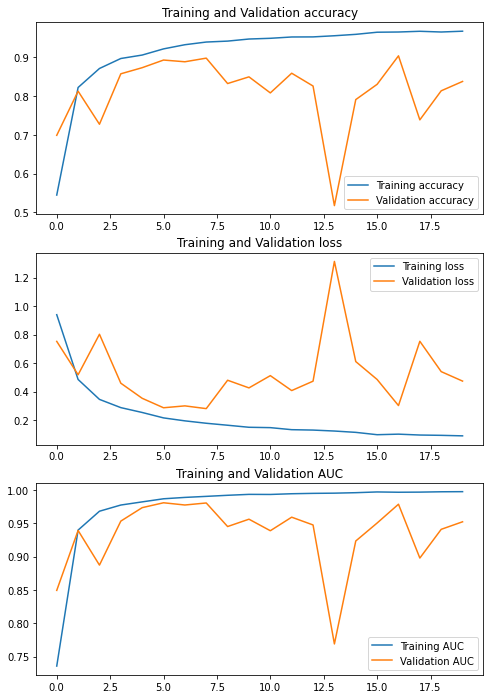

In [8]:
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
plt.subplot(3, 1, 1)
plt.title('Training and Validation accuracy')
plt.plot(history.epoch, history.history['accuracy'], label='Training accuracy')
plt.plot(history.epoch, history.history['val_accuracy'], label='Validation accuracy')
plt.legend()

plt.subplot(3, 1, 2)
plt.title('Training and Validation loss')
plt.plot(history.epoch, history.history['loss'], label='Training loss')
plt.plot(history.epoch, history.history['val_loss'], label='Validation loss')
plt.legend()

plt.subplot(3, 1, 3)
plt.title('Training and Validation AUC')
plt.plot(history.epoch, history.history['AUC'], label='Training AUC')
plt.plot(history.epoch, history.history['val_AUC'], label='Validation AUC')
plt.legend()

plt.show()

In [9]:
import pandas as pd
hist_df = pd.DataFrame(history.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_loss'],ascending=True)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall,lr
epoch,,,,,,,,,,,
7,0.178839,0.939102,0.990173,0.944297,0.933954,0.281498,0.897638,0.980287,0.900892,0.894685,0.000100
5,0.216439,0.921468,0.986569,0.929384,0.912486,0.287522,0.892717,0.980592,0.903518,0.884843,0.000100
6,0.195679,0.932202,0.988617,0.939256,0.926396,0.300757,0.888287,0.977247,0.895552,0.881890,0.000100
16,0.102435,0.964951,0.996357,0.966601,0.963636,0.302875,0.903543,0.978418,0.909453,0.899606,0.000100
4,0.254461,0.905586,0.981916,0.915828,0.897371,0.353936,0.873031,0.973278,0.880261,0.864665,0.000100
11,0.133812,0.952136,0.994117,0.955147,0.949288,0.408081,0.858760,0.959010,0.861194,0.851870,0.000100
9,0.150655,0.946878,0.993176,0.951586,0.942935,0.426887,0.849409,0.955999,0.854935,0.843996,0.000100
3,0.288499,0.896714,0.977204,0.908405,0.883133,0.459756,0.857283,0.953134,0.865664,0.849902,0.000100
12,0.131039,0.952355,0.994678,0.954876,0.950274,0.473951,0.825787,0.947378,0.827363,0.818406,0.000100


#### Fine-tune ChexNet

In [10]:
history_finetune = chexnet_model.fit(train_generator,
                            epochs=35,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history.epoch[-1],
                            callbacks=[checkpoint,lambdacb])

Beginning training
Learning rate:  3.1622774e-05
Epoch 20/35
286/286 [==============================] - ETA: 0s - loss: 0.0909 - accuracy: 0.9689 - AUC: 0.9971 - precision: 0.9708 - recall: 0.9671
Epoch 00020: val_loss did not improve from 0.28150
End of epoch 19. Learning rate: 3.1622774e-05
286/286 [==============================] - 120s 398ms/step - loss: 0.0909 - accuracy: 0.9689 - AUC: 0.9971 - precision: 0.9708 - recall: 0.9671 - val_loss: 0.4368 - val_accuracy: 0.8435 - val_AUC: 0.9570 - val_precision: 0.8479 - val_recall: 0.8396
Learning rate:  3.1622774e-05
Epoch 21/35
286/286 [==============================] - ETA: 0s - loss: 0.0872 - accuracy: 0.9689 - AUC: 0.9972 - precision: 0.9704 - recall: 0.9674
Epoch 00021: val_loss did not improve from 0.28150
End of epoch 20. Learning rate: 3.1622774e-05
286/286 [==============================] - 114s 396ms/step - loss: 0.0872 - accuracy: 0.9689 - AUC: 0.9972 - precision: 0.9704 - recall: 0.9674 - val_loss: 0.3988 - val_accuracy: 0.8

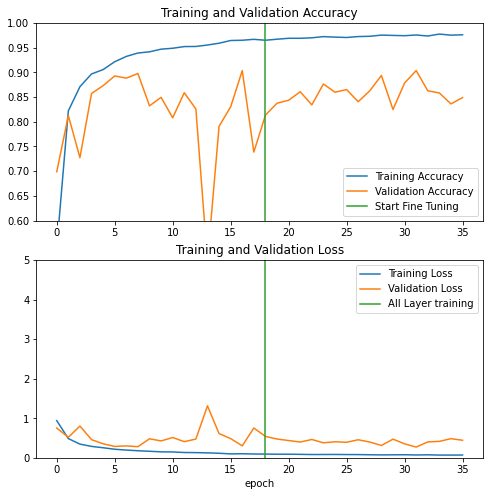

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
initial_epochs=history.epoch[-1]

acc += history_finetune.history['accuracy']
val_acc += history_finetune.history['val_accuracy']
loss += history_finetune.history['loss']
val_loss += history_finetune.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 5.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='All Layer training')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [12]:
hist_df = pd.DataFrame(history_finetune.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_accuracy'],ascending=False)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall
epoch,,,,,,,,,,
11,0.071519,0.975575,0.998010,0.976839,0.974699,0.271351,0.903543,0.980970,0.904785,0.902559
8,0.073402,0.975356,0.997709,0.975757,0.974261,0.311536,0.893701,0.976909,0.894763,0.891240
10,0.077391,0.974151,0.997618,0.975511,0.972946,0.352904,0.878445,0.970664,0.880693,0.875492
3,0.083588,0.972289,0.997203,0.973003,0.971084,0.378878,0.876476,0.967815,0.879148,0.873524
5,0.082321,0.970537,0.997796,0.972213,0.969551,0.393504,0.865157,0.964411,0.869177,0.863189
7,0.076967,0.972946,0.997909,0.973765,0.971632,0.398196,0.862697,0.965045,0.866138,0.859744
12,0.075840,0.973494,0.997645,0.975069,0.972399,0.401848,0.862697,0.963507,0.867691,0.861713
1,0.087192,0.968894,0.997158,0.970443,0.967360,0.398803,0.860728,0.963605,0.863095,0.856299
4,0.084389,0.971303,0.997442,0.972869,0.970099,0.405476,0.859744,0.961459,0.863095,0.856299


In [13]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
chexnet_model.compile(
    optimizer=adam_optimizer,
    loss= LOSS_METRIC,
    metrics=["accuracy",
             tf.keras.metrics.AUC(name='AUC'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')],
)
history_finetune2 = chexnet_model.fit(train_generator,
                            epochs=45,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune.epoch[-1],
                            callbacks=[checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 35/45
286/286 [==============================] - ETA: 0s - loss: 0.0717 - accuracy: 0.9734 - AUC: 0.9982 - precision: 0.9749 - recall: 0.9728
Epoch 00035: val_loss did not improve from 0.27135
End of epoch 34. Learning rate: 1e-04
286/286 [==============================] - 124s 398ms/step - loss: 0.0717 - accuracy: 0.9734 - AUC: 0.9982 - precision: 0.9749 - recall: 0.9728 - val_loss: 0.2985 - val_accuracy: 0.9016 - val_AUC: 0.9771 - val_precision: 0.9045 - val_recall: 0.8991
Learning rate:  1e-04
Epoch 36/45
286/286 [==============================] - ETA: 0s - loss: 0.0679 - accuracy: 0.9763 - AUC: 0.9983 - precision: 0.9773 - recall: 0.9756
Epoch 00036: val_loss did not improve from 0.27135
End of epoch 35. Learning rate: 1e-04
286/286 [==============================] - 114s 396ms/step - loss: 0.0679 - accuracy: 0.9763 - AUC: 0.9983 - precision: 0.9773 - recall: 0.9756 - val_loss: 0.6543 - val_accuracy: 0.7997 - val_AUC: 0.9292 - val_prec

In [15]:
hist_df = pd.DataFrame(history_finetune2.history) 
hist_df.index.name='epoch'
hist_df.sort_values(by=['val_accuracy'],ascending=False)

,loss,accuracy,AUC,precision,recall,val_loss,val_accuracy,val_AUC,val_precision,val_recall
epoch,,,,,,,,,,
9,0.054637,0.980942,0.998982,0.981996,0.979737,0.206964,0.932579,0.987761,0.934321,0.931102
5,0.066554,0.976561,0.998057,0.977180,0.975575,0.301718,0.906988,0.977996,0.908687,0.906004
10,0.054496,0.979299,0.998843,0.980358,0.978532,0.313160,0.905020,0.974980,0.906265,0.904035
0,0.071718,0.973384,0.998200,0.974866,0.972837,0.298513,0.901575,0.977055,0.904455,0.899114
7,0.056860,0.979737,0.998773,0.980158,0.979299,0.344619,0.897638,0.973458,0.899604,0.895177
4,0.066154,0.976780,0.998276,0.977614,0.975794,0.334997,0.892717,0.972776,0.893439,0.891240
3,0.067097,0.976780,0.998230,0.978371,0.976013,0.341236,0.889272,0.973072,0.894841,0.887795
6,0.060339,0.979080,0.998525,0.979596,0.978094,0.442665,0.877953,0.963606,0.884903,0.874016
8,0.053272,0.979518,0.998912,0.979930,0.978642,0.621017,0.820866,0.938209,0.825199,0.815453


In [14]:
history_finetune3 = chexnet_model.fit(train_generator,
                            epochs=55,
                            validation_data=validation_generator,
                            verbose=1,
                            initial_epoch=history_finetune2.epoch[-1],
                            callbacks=[checkpoint,lambdacb])

Beginning training
Learning rate:  1e-04
Epoch 45/55
286/286 [==============================] - ETA: 0s - loss: 0.0523 - accuracy: 0.9828 - AUC: 0.9987 - precision: 0.9832 - recall: 0.9825
Epoch 00045: val_loss did not improve from 0.20696
End of epoch 44. Learning rate: 1e-04
286/286 [==============================] - 113s 393ms/step - loss: 0.0523 - accuracy: 0.9828 - AUC: 0.9987 - precision: 0.9832 - recall: 0.9825 - val_loss: 0.5417 - val_accuracy: 0.8209 - val_AUC: 0.9445 - val_precision: 0.8236 - val_recall: 0.8159
Learning rate:  1e-04
Epoch 46/55
286/286 [==============================] - ETA: 0s - loss: 0.0481 - accuracy: 0.9841 - AUC: 0.9990 - precision: 0.9844 - recall: 0.9837
Epoch 00046: val_loss did not improve from 0.20696
End of epoch 45. Learning rate: 1e-04
286/286 [==============================] - 112s 391ms/step - loss: 0.0481 - accuracy: 0.9841 - AUC: 0.9990 - precision: 0.9844 - recall: 0.9837 - val_loss: 0.4637 - val_accuracy: 0.8652 - val_AUC: 0.9615 - val_prec

### Model Evaluation

In [16]:
TEST_IMAGE_FOLDER = '/home/TBX11K/CLAHE/test/Montgomery'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

model = tf.keras.models.load_model('./weights/chexnet_clahe.hdf5')
res = model.predict(test_generator)

Found 69 images belonging to 3 classes.


In [17]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.93      0.65      0.76        40
           1       0.00      0.00      0.00         0
           2       0.67      0.90      0.76        29

    accuracy                           0.75        69
   macro avg       0.53      0.52      0.51        69
weighted avg       0.82      0.75      0.76        69



#### Shenzhen Evaluation

In [18]:
TEST_IMAGE_FOLDER = '/home/TBX11K/CLAHE/test/Shenzhen'
test_generator = test_datagen.flow_from_directory(
        TEST_IMAGE_FOLDER,
        target_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False,
        class_mode=CLASS_MODE)

res = model.predict(test_generator)

Found 331 images belonging to 3 classes.


In [19]:
from sklearn.metrics import classification_report
predicted = np.argmax(res, axis=1)
report = classification_report(test_generator.classes, predicted)
print(report)

              precision    recall  f1-score   support

           0       0.91      0.69      0.79       163
           2       0.76      0.93      0.84       168

    accuracy                           0.82       331
   macro avg       0.83      0.81      0.81       331
weighted avg       0.83      0.82      0.81       331

